## 1) Recap on RFE models and scenarios

i) Use dependencies and MarketDataBuilder to generate (10k) simulated paths for EUR ZERO YIELD CURVE.

The calibration should be based on direct input (this may require some adjustments to calibra-
tion parameters...). 

The schedule should be monthly for the period ['2020-01-01', '2040-01-01'].

Finally, check/show the paths using the same utility functions used at lesson.

In [2]:
import sys
sys.path.append('..')

import numpy as np

import pandas as pd

from pimpa.market_data_objects.curve import Curve
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from pimpa.market_data_objects.correlation_matrix import CorrelationMatrix
from pimpa.data_objects.simulated_hw1f_curve import SimulatedHW1FCurve
from pimpa.scenario_generation.brownian_motion import BrownianMotion
from pimpa.scenario_generation.geometric_brownian_motion import GeometricBrownianMotion
from pimpa.scenario_generation.hw1f import HW1F
from pimpa.scenario_generation.multi_risk_factor_simulation import MultiRiskFactorSimulation
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule,transform_dates_to_time_differences
from pimpa.utils.notebook_tools import test_rfe_mean_and_vola, plot_rfe_paths, simulate_single_risk_factor
from pimpa.utils.notebook_tools import test_scenarios_marginal_distributions, test_scenarios_correlations
from data.configuration.global_parameters import global_parameters

In [3]:
starting_date = '2020-01-01'
final_date = '2040-01-01'
valuation_frequency = 'monthly'
global_parameters['n_paths'] = 1000
nr_paths = global_parameters['n_paths'] #10k
simulation_dates = generate_simulation_dates_schedule(starting_date, final_date, valuation_frequency, global_parameters)

EUR_ZERO_YIELD_CURVE with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.04
 - volatility: 0.02


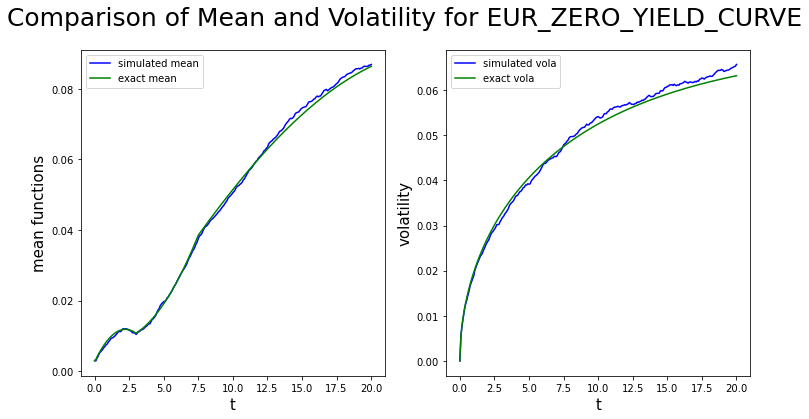

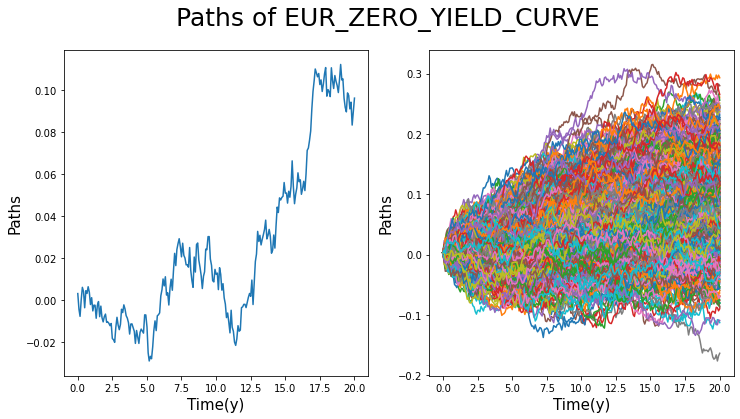

In [4]:
from data.configuration.global_parameters import calibration_parameters

# if have, do not add, if not, add into calibration_parameters.
# calibration_parameters = {'RFE_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'calibration_method': 'direct_input'}}} 

S_HW1F = HW1F('EUR_ZERO_YIELD_CURVE')

RFE_dependencies = S_HW1F.get_dependencies(calibration_parameters)
market_data = MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_HW1F.calibrate(market_data = market_data, calibration_parameters = calibration_parameters)
print(S_HW1F)
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths) # (10000, 241)
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

ii) Use dependencies and MarketDataBuilder to generate coherent scenarios inclusive of:
- EUR ZERO YIELD CURVE
- USD ZERO YIELD CURVE
- EUR USD FX RATE

and check/show the paths using the same utility functions used at lesson.

In [5]:
#Simulated RFs objects
simulated_risk_factors = set(['EUR_ZERO_YIELD_CURVE','USD_ZERO_YIELD_CURVE','EUR_USD_FX_RATE'])

simulated_risk_factor_objects = MarketDataBuilder().get_risk_factors(simulated_risk_factors, global_parameters)
print(simulated_risk_factor_objects)

#Construction of the RFs market data
RFE_dependencies = set()
for RF in simulated_risk_factors:
    model = simulated_risk_factor_objects[RF].model
    RFE_dependencies.update(model.get_dependencies(calibration_parameters))

market_data = MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
print(market_data) 

#Calibration of the RFs models 
_ = [rf.model.calibrate(market_data, calibration_parameters) for rf in simulated_risk_factor_objects.values()]

print(simulated_risk_factor_objects['EUR_ZERO_YIELD_CURVE'].model)
print(simulated_risk_factor_objects['USD_ZERO_YIELD_CURVE'].model)
print(simulated_risk_factor_objects['EUR_USD_FX_RATE'].model)


#Load the correlation matrix
correlation_matrix = CorrelationMatrix(file_path = global_parameters['prototype_data_paths']['RFE'] + \
                                       global_parameters['prototype_data_files']['RFE']['RFE_correlation_matrix'])
# print(correlation_matrix.correlation_matrix)

scenario_object = MultiRiskFactorSimulation(simulated_risk_factor_objects.values(), correlation_matrix)
simulated_scenarios=scenario_object.generate_scenarios(simulation_dates, global_parameters)

{'EUR_ZERO_YIELD_CURVE': RiskFactor(name='EUR_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='EUR', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x000001ECEC0848E0>, model_name='HW1F', reference=None), 'USD_ZERO_YIELD_CURVE': RiskFactor(name='USD_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='USD', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x000001ECEC084BE0>, model_name='HW1F', reference=None), 'EUR_USD_FX_RATE': RiskFactor(name='EUR_USD_FX_RATE', asset_class='FX', asset_type='SPOT', currency='EUR', simulated=True, model=<pimpa.scenario_generation.geometric_brownian_motion.GeometricBrownianMotion object at 0x000001ECEC084A30>, model_name='GBM', reference=None)}
{'RFE_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04, 'volatility': 0.02, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x000001ECC39C7A30>}, 'USD_ZERO_YIELD_CURVE': {'alpha': 0.05, 'volatilit

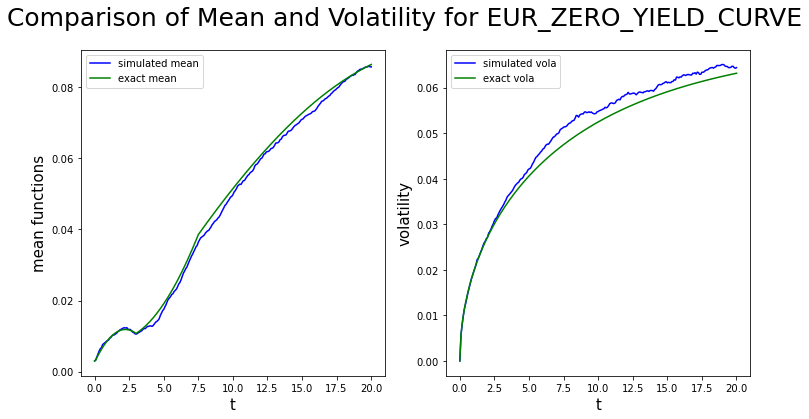

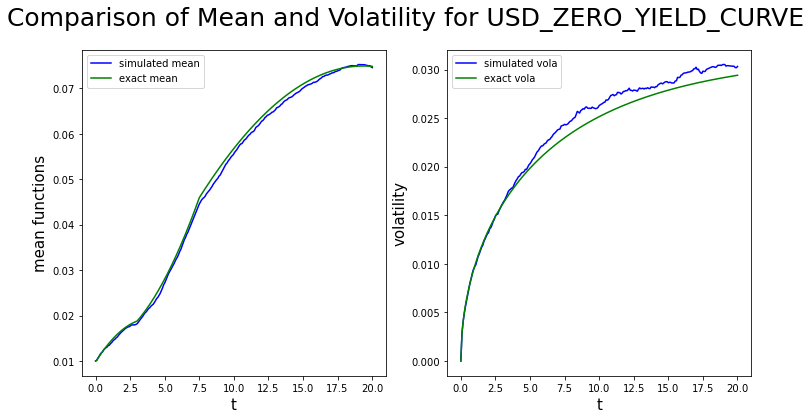

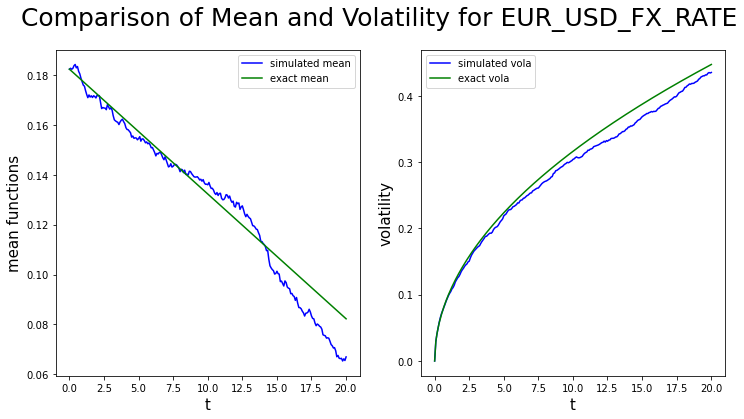

The max observed error in correlations is 0.004575817364191506
                                             realised_correlations  \
EUR_ZERO_YIELD_CURVE_X_EUR_ZERO_YIELD_CURVE               1.000000   
EUR_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE               0.899523   
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE               1.000000   
EUR_USD_FX_RATE_X_EUR_ZERO_YIELD_CURVE                    0.204008   
EUR_USD_FX_RATE_X_USD_ZERO_YIELD_CURVE                    0.104576   
EUR_USD_FX_RATE_X_EUR_USD_FX_RATE                         1.000000   

                                             true_correlations  
EUR_ZERO_YIELD_CURVE_X_EUR_ZERO_YIELD_CURVE                1.0  
EUR_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                0.9  
USD_ZERO_YIELD_CURVE_X_USD_ZERO_YIELD_CURVE                1.0  
EUR_USD_FX_RATE_X_EUR_ZERO_YIELD_CURVE                     0.2  
EUR_USD_FX_RATE_X_USD_ZERO_YIELD_CURVE                     0.1  
EUR_USD_FX_RATE_X_EUR_USD_FX_RATE                       

In [6]:
# test_scenarios
test_scenarios_marginal_distributions(simulated_scenarios, scenario_object)
correlations, max_error = test_scenarios_correlations(simulated_scenarios, scenario_object, correlation_matrix)
print(f'The max observed error in correlations is {max_error}')
print(correlations)

## 2) Recap on trades and pricing models

i) Add a new trade (3234) to the relevant data feeds. Such trade should be a receiver EUR LIBOR 3M
swap with same residual characteristics as trade 1234.


In [7]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

from pimpa.trade_models.portfolio import Portfolio
from pimpa.trade_models.interest_rate_swap import InterestRateSwap
from pimpa.trade_models.equity_european_option import EquityEuropeanOption
from pimpa.pricing_models.interest_rate_swap_pricer import InterestRateSwapPricer
from pimpa.pricing_models.equity_european_option_pricer import EquityEuropeanOptionPricer
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule
from pimpa.utils.calendar_utils import transform_dates_to_time_differences
from data.configuration.global_parameters import global_parameters, calibration_parameters


In [8]:
# portfolio data - master_ledger | desks - IR | ? counterparties - 23|

# 1234,IRS,23,MAIN,VM_1,NOT_AVAILABLE,NOT_AVAILABLE
# 3234,IRS,23,MAIN,VM_1,NOT_AVAILABLE,NOT_AVAILABLE  # 

In [9]:
trade_id = 3234
risk_factors = pd.read_csv(global_parameters['prototype_data_paths']['RFs_attributes'] + global_parameters['prototype_data_files']['RFs_attributes']['all_RFs_mapping'])
trade = InterestRateSwap(trade_id)
trade.load(global_parameters, risk_factors)
print('-----------------------------')
print(trade)
print('-----------------------------')

-----------------------------
Trade with trade_id: 3234
- trade type: IRS
- asset class: IR
- trade currency: USD
- trade underlyings: ['EUR_LIBOR_3M_CURVE', 'EUR_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fixings_schedule', 'payments_schedule'])
- with 41 valuation points.
AVAILABLE
-----------------------------


In [10]:
pricer = InterestRateSwapPricer('IRS_Pricer')
risk_factor_objects = MarketDataBuilder().get_risk_factors(trade.trade_underlyings, global_parameters)

print(f"rf_obj: {risk_factor_objects}")

pricer_dependencies = pricer.get_market_dependencies(trade.trade_underlyings, risk_factor_objects,calibration_parameters)
print(f"PrDe:{pricer_dependencies}")

market_data = MarketDataBuilder().load_market_data(pricer_dependencies, global_parameters)
# print('-----------------------------')
# print(f"MkDt:{market_data}")
# print('-----------------------------')
pricer.calibrate(market_data, calibration_parameters)
print(pricer)
print('-----------------------------')

rf_obj: {'EUR_ZERO_YIELD_CURVE': RiskFactor(name='EUR_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='EUR', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x000001ECEC2A2BE0>, model_name='HW1F', reference=None), 'EUR_LIBOR_3M_CURVE': RiskFactor(name='EUR_LIBOR_3M_CURVE', asset_class='IR', asset_type='SPREAD_TO_DISCOUNT_CURVE', currency='EUR', simulated=False, model=None, model_name='NOT_AVAILABLE', reference='EUR_ZERO_YIELD_CURVE')}
PrDe:{('historical_fixings', 'EUR_LIBOR_3M_CURVE'), ('historical_fixings', 'EUR_ZERO_YIELD_CURVE'), ('Pricing_HW1F_calibration', 'EUR_ZERO_YIELD_CURVE'), ('spread_to_discount_curve', 'EUR_LIBOR_3M_CURVE')}
-----------------------------


In [11]:
pricer.calibration

{'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04,
  'volatility': 0.02,
  'rate_curve': <pimpa.market_data_objects.curve.Curve at 0x1ece5fc1d00>}}

In [12]:
market_data

{'historical_fixings': {'EUR_LIBOR_3M_CURVE': 2020-01-01    0.001
  2019-12-31    0.001
  2019-12-30    0.001
  2019-12-29    0.001
  2019-12-28    0.001
                ...  
  2018-12-18    0.001
  2018-12-17    0.001
  2018-12-16    0.001
  2018-12-15    0.001
  2018-12-14    0.001
  Name: EUR_LIBOR_3M_CURVE, Length: 384, dtype: float64,
  'EUR_ZERO_YIELD_CURVE': 2020-01-01    0.005
  2019-12-31    0.010
  2019-12-30    0.010
  2019-12-29    0.010
  2019-12-28    0.010
                ...  
  2018-12-18    0.010
  2018-12-17    0.010
  2018-12-16    0.010
  2018-12-15    0.010
  2018-12-14    0.010
  Name: EUR_ZERO_YIELD_CURVE, Length: 384, dtype: float64},
 'Pricing_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04,
   'volatility': 0.02,
   'rate_curve': <pimpa.market_data_objects.curve.Curve at 0x1ece5fc1d00>}},
 'spread_to_discount_curve': {'EUR_LIBOR_3M_CURVE': <pimpa.market_data_objects.curve.Curve at 0x1ecec2a29a0>}}

In [13]:
 market_data['spread_to_discount_curve']

{'EUR_LIBOR_3M_CURVE': <pimpa.market_data_objects.curve.Curve at 0x1ecec2a29a0>}

ii) Value the trade according to the scenarios generated in the previous exercise and display the
average MtM as a function of time.

In [18]:
valuation_dates = simulation_dates
scenarios = {'EUR_ZERO_YIELD_CURVE': np.random.normal(loc=0.003, scale=0.02, size=(nr_paths, len(valuation_dates)))}
trade_mtms = pricer.price_single_trade(trade, valuation_dates, scenarios, market_data, global_parameters)

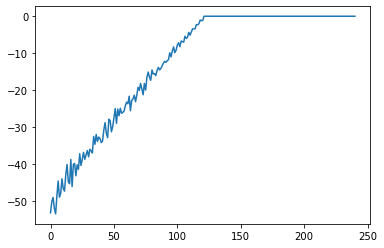

In [19]:
MtM_mean = np.mean(trade_mtms, axis = 0)
import matplotlib.pyplot as plt
plt.plot(MtM_mean)

## 3.Recap on portfolio valuation

i) Create a new portfolio (27) with the following characteristics:
- Trades: 3234, 3235 (where 3235 is identical to 1234)
- Settlement currency: EUR
- Netting: a single netting set MAIN containing 3235 and 3234
- Collateral agreement: VM 1 containing 3235 and 3234 with the same contractual terms as
VM 1 in netting agreement 23

ii) For portfolio 27 provide the following:
- The EE and PE(95%) for a longer MPOR=4w, coll. and uncoll.
- A plot of the average portfolio value vs. time.
- A plot of the average collateral requirements vs. time.
- A plot of the average trade 3235 value vs. time (in USD).
- A plot of the average trade 3235 value vs. time (in the settlement currency).